# Exploring SFPD Police Incident Report Data
The dataset available has SFPD police incident report data from January 2003 to May 2018. The goal is to perform analysis on the available data to discern trends over the years in San Francisco's crime scene.

The data is freely available at [datasf.org](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry).


In [6]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# read data from csv file
data = pd.read_csv("./data/SFPD-Incident-Reports-Jan2003-May2018.csv")

#preview rows,cols
#print(data.shape)
data.info()

#preview data
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129525 entries, 0 to 2129524
Data columns (total 35 columns):
 #   Column                                                    Dtype  
---  ------                                                    -----  
 0   PdId                                                      int64  
 1   IncidntNum                                                int64  
 2   Incident Code                                             int64  
 3   Category                                                  object 
 4   Descript                                                  object 
 5   DayOfWeek                                                 object 
 6   Date                                                      object 
 7   Time                                                      object 
 8   PdDistrict                                                object 
 9   Resolution                                                object 
 10  Address                       

,PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,...,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
0,3114751606302,31147516,6302,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,09/28/2003,10:00,SOUTHERN,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5069701104134,50697011,4134,ASSAULT,BATTERY,Wednesday,06/22/2005,12:20,NORTHERN,NONE,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,97.0
2,6074729204104,60747292,4104,ASSAULT,ASSAULT,Saturday,07/15/2006,00:55,CENTRAL,NONE,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,106.0
3,7103536315201,71035363,15201,ASSAULT,STALKING,Tuesday,09/25/2007,00:01,TARAVAL,NONE,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,49.0
4,11082415274000,110824152,74000,MISSING PERSON,MISSING ADULT,Saturday,09/24/2011,11:00,TARAVAL,LOCATED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 35 columns but we definitely don't need them all. It also looks like there may be null values throughout the dataset. Of particular interest is the Date and Time columns which we can use for temporal analysis. We also need to check for nulls and duplicates and drop them from our dataset.

In [8]:
# lets read the csv data again but this time parse the date and time columns as datetime
data = pd.read_csv("./data/SFPD-Incident-Reports-Jan2003-May2018.csv", parse_dates=[['Date','Time']])

#we don't need all 35 columns, so lets select what we determine to be relevant
data = data[["Date_Time","Category","Descript",'DayOfWeek',"PdDistrict","Resolution","Address","X","Y"]]

#preview rows,cols
data.info()

#preview data
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129525 entries, 0 to 2129524
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Date_Time   datetime64[ns]
 1   Category    object        
 2   Descript    object        
 3   DayOfWeek   object        
 4   PdDistrict  object        
 5   Resolution  object        
 6   Address     object        
 7   X           float64       
 8   Y           float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 146.2+ MB


,Date_Time,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2003-09-28 10:00:00,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.500000,90.000000
1,2005-06-22 12:20:00,ASSAULT,BATTERY,Wednesday,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223,37.781896
2,2006-07-15 00:55:00,ASSAULT,ASSAULT,Saturday,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672,37.799789
3,2007-09-25 00:01:00,ASSAULT,STALKING,Tuesday,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226,37.741362
4,2011-09-24 11:00:00,MISSING PERSON,MISSING ADULT,Saturday,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459173,37.708200


In [9]:
#check for nulls
data.isnull().sum()

Date_Time     0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    1
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [10]:
#drop nulls
data.dropna(inplace=True)

data.isnull().sum()

Date_Time     0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [11]:
#check how many duplicate entries there are
data.duplicated().sum()

5520

In [12]:
#drop duplicate entries
data.drop_duplicates(subset=None, keep="first", inplace=True)

#preview rows,cols
data.info()

#preview data
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2124004 entries, 0 to 2129524
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Date_Time   datetime64[ns]
 1   Category    object        
 2   Descript    object        
 3   DayOfWeek   object        
 4   PdDistrict  object        
 5   Resolution  object        
 6   Address     object        
 7   X           float64       
 8   Y           float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 162.0+ MB


,Date_Time,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2003-09-28 10:00:00,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.500000,90.000000
1,2005-06-22 12:20:00,ASSAULT,BATTERY,Wednesday,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223,37.781896
2,2006-07-15 00:55:00,ASSAULT,ASSAULT,Saturday,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672,37.799789
3,2007-09-25 00:01:00,ASSAULT,STALKING,Tuesday,TARAVAL,NONE,400 Block of ULLOA ST,-122.458226,37.741362
4,2011-09-24 11:00:00,MISSING PERSON,MISSING ADULT,Saturday,TARAVAL,LOCATED,3200 Block of SAN JOSE AV,-122.459173,37.708200


We can infer from the number of rows that there are 2,129,525 number of crimes in the dataset. Of which around 5,520 were duplicates and one had a null value leaving a total of 2,124,004 crimes.

We've cleaned up this data enough to finally start some descriptive analysis of the data. We can determine the different categories of crimes and number of crimes in each category.

In [13]:
num_crimes_cat = data["Category"].value_counts()
print(num_crimes_cat)

LARCENY/THEFT                  476104
OTHER OFFENSES                 301437
NON-CRIMINAL                   235990
ASSAULT                        166909
VEHICLE THEFT                  125999
DRUG/NARCOTIC                  117679
VANDALISM                      114406
WARRANTS                        99687
BURGLARY                        90744
SUSPICIOUS OCC                  79027
ROBBERY                         54433
MISSING PERSON                  43953
FRAUD                           41246
FORGERY/COUNTERFEITING          22946
SECONDARY CODES                 22364
WEAPON LAWS                     20993
TRESPASS                        19168
PROSTITUTION                    16245
STOLEN PROPERTY                 11441
DISORDERLY CONDUCT               9921
DRUNKENNESS                      9754
SEX OFFENSES, FORCIBLE           8710
RECOVERED VEHICLE                8677
DRIVING UNDER THE INFLUENCE      5649
KIDNAPPING                       4281
ARSON                            3872
EMBEZZLEMENT

It seems that the most prevalent type of crime from 2003 to 2018 is larceny/theft. We can plot a bar chart to visualise the data here.

<AxesSubplot:title={'center':'Crime occurences by category'}, xlabel='Category', ylabel='Occurences'>

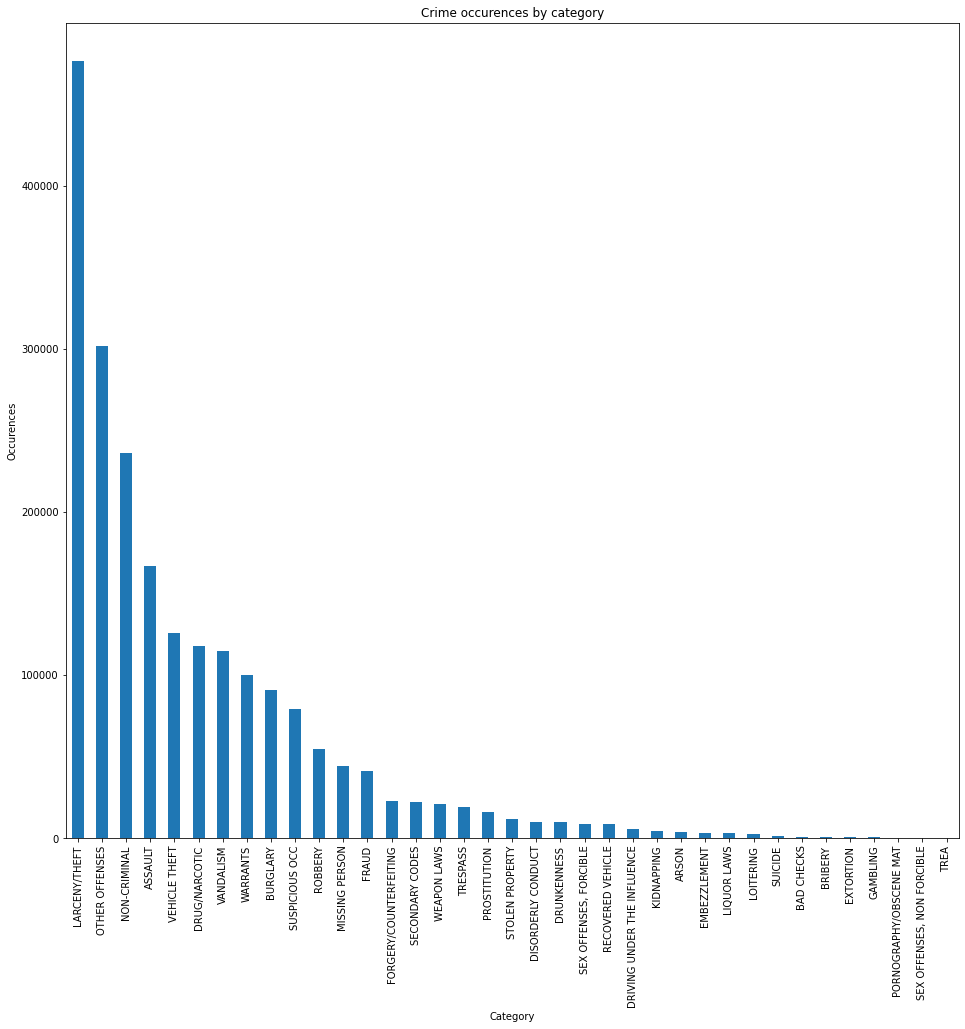

In [14]:
plt.figure()
num_crimes_cat.plot(kind='bar',xlabel='Category',ylabel='Occurences',title='Crime occurences by category',figsize=(16,15))

We can also check which day has the highest number of crimes committed.

<AxesSubplot:title={'center':'Crime occurences by day of the week'}, xlabel='Day', ylabel='Occurences'>

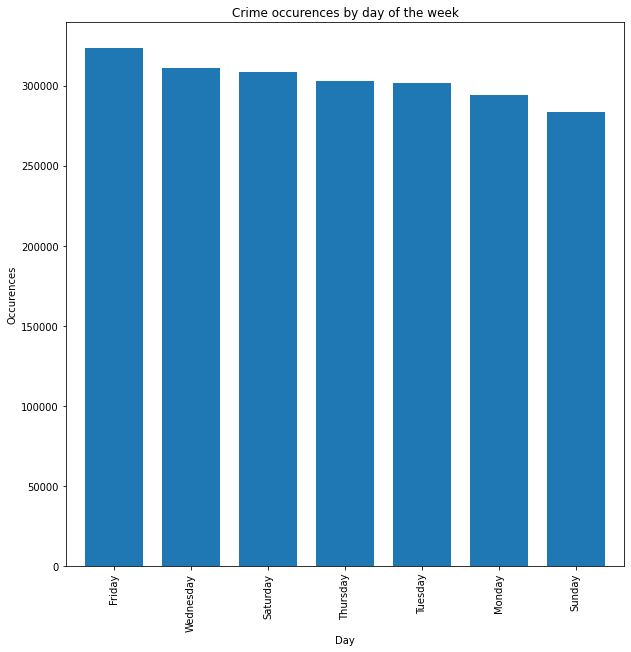

In [15]:
crime_days = data["DayOfWeek"].value_counts()
crime_days.plot(kind='bar',xlabel='Day',ylabel='Occurences',title='Crime occurences by day of the week',figsize=(10,10),width=0.75)

We can check the descriptions and see what is the most prevalent as well.

<AxesSubplot:title={'center':'Crime occurences vs Description'}, xlabel='Description', ylabel='Occurences'>

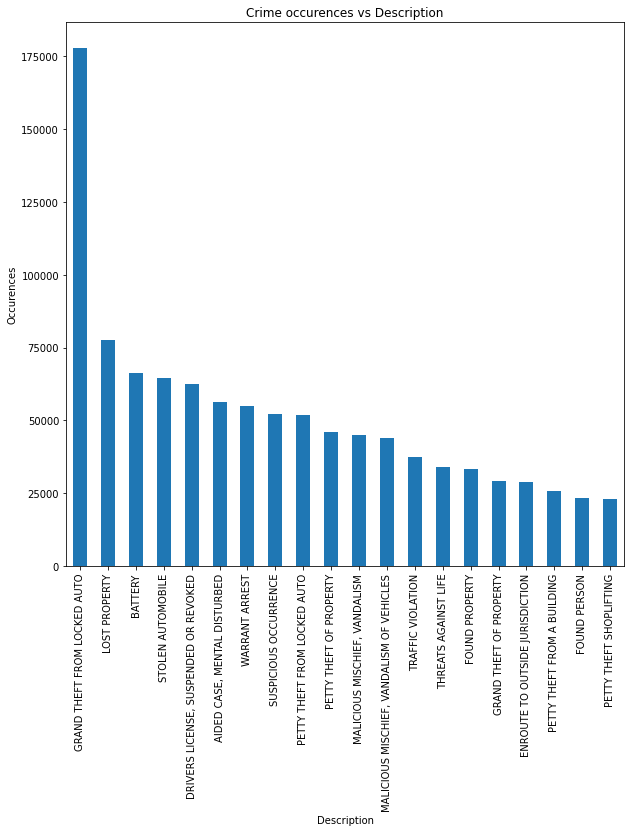

In [24]:
desc = data["Descript"].value_counts()
# limit to top 20 due to volume of descriptions
desc[:20].plot(kind='bar',xlabel='Description',ylabel='Occurences',title='Crime occurences vs Description', figsize=(10,10))

We can breakdown the Date_Time column to split data by year, month and day. Note that we only have data till May 2018.

In [30]:
data['Year'] = pd.DatetimeIndex(data['Date_Time']).year
data['Month'] = pd.DatetimeIndex(data['Date_Time']).month
data['Day'] = pd.DatetimeIndex(data['Date_Time']).day

<AxesSubplot:title={'center':'Crime occurences per year'}, xlabel='Year', ylabel='Occurences'>

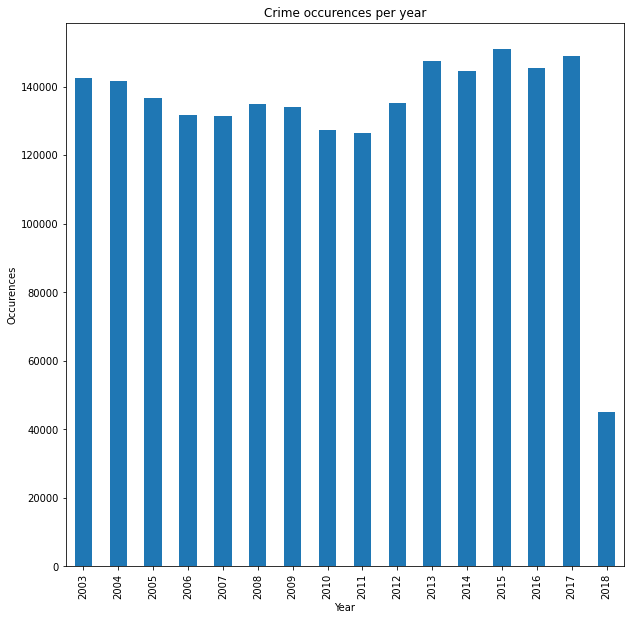

In [39]:
years_data = data['Year'].value_counts().sort_index()
years_data.plot(kind='bar',xlabel='Year',ylabel='Occurences',title='Crime occurences per year', figsize=(10,10))